<h1>Jak poznat autora textu?</h1>
Petr Plecháč, ÚČL AV ČR<br>
Týden vědy a techniky

<div style='border-bottom: 5px solid grey;padding-top:40px; padding-bottom: 20px'>

Shluková analýza textů na základě míry Delta.

<p><b>Data:</b>
<br>    české texty; zdroj: <a href='http://versologie.cz' target='_blank'>Korpus českého verše</a>
<br>    anglické texty; zdroj: <a href='https://www.frontiersin.org/articles/10.3389/fdigh.2018.00005/full' target='_blank'>Gutenberg English Poetry Corpus</a>
<br>    španělské texty; zdroj: <a href='https://github.com/bncolorado/CorpusSonetosSigloDeOro' target='_blank'>Corpus de Sonetos del Siglo de Oro</a>
</div>

In [76]:
import json
import re
import pandas as pd
from collections import defaultdict
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt 
import seaborn as sns

<h2>Volitelné parametry</h2>

In [92]:
# Vybrat korpus (povolené hodnoty: 'cs', 'en', 'es')
lang = 'es'
# Hladina MFT (kolik nejfrekventovanějších slov bude analyzováno)
mft = 100

<h2>Příprava dat</h2>

Načtení dat<p>
Data máme uložená v JSONu se strukturou:
<pre>
[{  <= Každá sbírka je jeden element v poli
    'author': (str) jméno autora,
    'title': (str) název sbírky,
    'words': (list) slova obsažená ve sbírce (tokeny)
}...]
</pre>

In [93]:
with open (lang+'.json') as file:
    data = json.load(file)

Výpočet absolutních frekvencí slov

In [94]:
frequencies = defaultdict(lambda: defaultdict(int))

for x in data:
    # Příjmení autora
    surname = re.sub(',.*', '', x['author'])
    # Zkrátit dlouhé názvy sbírek
    tit = re.sub(' o ptáku Velikánu Velikánoviči| veršovaných prací', '', x['title'])
    # Příjmení a název sbírky v jednom řetězci
    key = '{0}: {1}'.format(surname, tit)
    # Frekvence slov (lowercase)
    for w in x['words']:
        frequencies[key][w.lower()] += 1

<h2>Analýza</h2>

Frekvence slov, transformace na z-skóry

In [95]:
# PARAM: Kolik nejfrekventovanějších slov? 


# Nalít data do dataframu
df = pd.DataFrame(frequencies).fillna(0).T

# Extrahovat nejčetnější slova
most_frequent = df.sum().sort_values(ascending=False)[0:mft].index
df = df[most_frequent]

# Absolutní četnosti na relativní
df = df.div(df.sum(axis=1), axis=0)

# Transformace na z-skóry
df = (df - df.mean())/df.std(ddof=0)
df = df.fillna(0)

Konstrukce dendrogramu

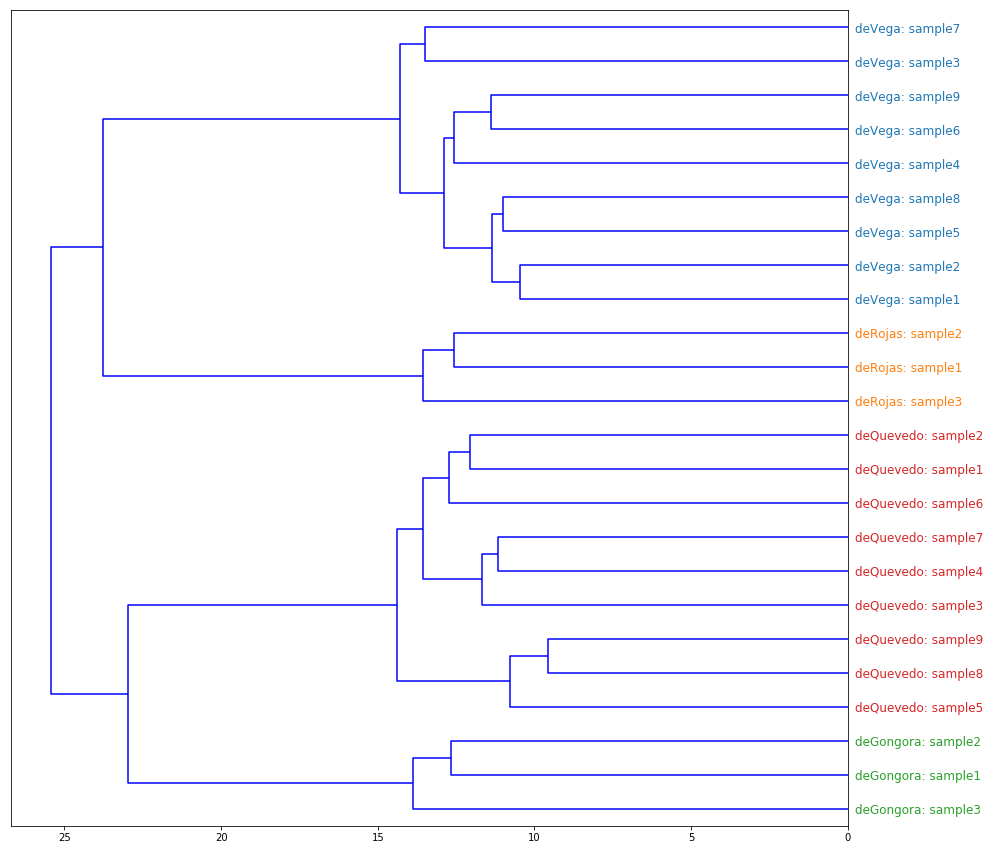

In [96]:
keys = [x[0:4] for x in df.index.tolist() ]
keys_unique = list(set(keys))
c_labels = [keys_unique.index(x) for x in keys]
leaves = []
leaves_c = dict()
for i,x in enumerate(list(df.index)):
    leaves.append(x)
    leaves_c[x] = sns.color_palette(n_colors = len(keys_unique))[c_labels[i]]

fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111)
c_link = linkage(df, metric='euclidean', method='ward')
    
dendrogram(c_link,labels=leaves, orientation='left', color_threshold=0, leaf_font_size=12.)

xlbls = ax.get_ymajorticklabels()
for lbl in xlbls:
    lbl.set_color(leaves_c[lbl.get_text()]) 
